# Analiza wpływu skali i wyboru słów na wydajność (JOIN + WINDOW)
## Spark SQL vs Python (pandas)

**Autor:** [Twoje imię i nazwisko]  
**Data:** 2024-11-19  

### Cel ćwiczenia
Zrozumienie, jak różne czynniki wpływają na wydajność analizy tekstowej w Spark SQL i klasycznym Pythonie (pandas).

## Kod bazowy - Inicjalizacja i funkcje pomocnicze

In [3]:
!pip install pyspark==3.5.2 nltk==3.9.\*


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import re, time, urllib.request, ssl
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# ============================================================
# I Przygotowanie środowiska NLTK (tokenizer do wersji Python)
# ============================================================
import nltk
from nltk.tokenize import word_tokenize

def _ensure_nltk():
    """Pobiera wymagane zasoby NLTK, jeśli nie są zainstalowane."""
    try: nltk.data.find('tokenizers/punkt')
    except LookupError: nltk.download('punkt', quiet=True)
    try: nltk.data.find('tokenizers/punkt_tab')
    except LookupError: nltk.download('punkt_tab', quiet=True)

_ensure_nltk()

In [43]:
# ============================================================
# II Inicjalizacja sesji Spark
# ============================================================
from pyspark.sql import SparkSession, functions as F, Window

spark = (
    SparkSession.builder
    .master("local[*]")
    .appName("ScaleBenchmarkSparkPython_FairReplication")
    .config("spark.sql.shuffle.partitions", "10")
    .config("spark.sql.adaptive.enabled", "true")
    .config("spark.driver.memory", "6g")
    .config("spark.executor.memory", "6g")
    .getOrCreate()
)

spark.sparkContext.setLogLevel("ERROR")
print("✓ Spark session initialized")

✓ Spark session initialized


In [44]:
# ============================================================
# III Przygotowanie danych wejściowych — sztuki Szekspira
# ============================================================
DATA_DIR = Path("./data_shakespeare")
DATA_DIR.mkdir(parents=True, exist_ok=True)

SOURCES = {
    "Hamlet": ("https://www.gutenberg.org/cache/epub/1524/pg1524.txt", DATA_DIR/"hamlet.txt"),
    "Macbeth": ("https://www.gutenberg.org/cache/epub/1533/pg1533.txt", DATA_DIR/"macbeth.txt"),
    "Romeo and Juliet": ("https://www.gutenberg.org/cache/epub/1513/pg1513.txt", DATA_DIR/"romeo_and_juliet.txt"),
}

def _dl(url, dest):
    """Pobiera plik z Gutenberga (bez walidacji SSL)."""
    if dest.exists(): return
    ctx = ssl.create_default_context(); ctx.check_hostname = False; ctx.verify_mode = ssl.CERT_NONE
    urllib.request.urlretrieve(url, dest)

# pobranie trzech tekstów
for _, (u,p) in SOURCES.items():
    _dl(u,p)
    
print("✓ Shakespeare texts downloaded")

✓ Shakespeare texts downloaded


In [45]:
# ============================================================
# IV Pomocnicze funkcje dla wersji Python (pandas)
# ============================================================
def clean_and_tokenize_py(txt:str):
    """Czyszczenie i tokenizacja tekstu w czystym Pythonie."""
    start = txt.lower().find("dramatis personae")
    if start == -1: start = 0
    txt = txt[start:]
    toks = [t.lower() for t in word_tokenize(txt)]
    toks = [re.sub(r"[^a-z']", "", t) for t in toks]
    return [t for t in toks if t]

def to_blocks(tokens, block_size):
    """Dzieli listę tokenów na bloki po block_size słów."""
    return [tokens[i:i+block_size] for i in range(0, len(tokens), block_size)]

In [46]:
# ============================================================
# V Główna funkcja benchmarku
# ============================================================
def benchmark(block_size, sources, keywords, window_radius, scales):
    """Uruchamia benchmark dla Python i Spark z różnymi skalami danych."""
    results = []  # lista do przechowywania czasów

    for MULTIPLIER in scales:
        print(f"\n=== TEST: MULTIPLIER = {MULTIPLIER} ===")

        # --------------------------------------------------------
        # 🔹 CZĘŚĆ A — Python (pandas)
        # --------------------------------------------------------
        t0_py = time.time()
        rows = []

        for play, (_, path) in sources.items():
            text = Path(path).read_text(encoding="utf-8", errors="ignore")
            tokens = clean_and_tokenize_py(text) * MULTIPLIER
            blocks = to_blocks(tokens, block_size)
            for block_id, block in enumerate(blocks):
                vocab, counts = np.unique(block, return_counts=True)
                freq = dict(zip(vocab, counts))
                for kw in keywords:
                    rows.append({"play": play, "block_id": block_id, "token": kw, "count": int(freq.get(kw, 0))})

        df = pd.DataFrame(rows).sort_values(["play","token","block_id"])
        df["roll_sum"] = (
            df.groupby(["play","token"])["count"]
              .transform(lambda s: s.rolling(2*window_radius+1, center=True, min_periods=1).sum())
        )
        python_elapsed = time.time() - t0_py

        # --------------------------------------------------------
        # 🔹 CZĘŚĆ B — Spark
        # --------------------------------------------------------
        _ = spark.range(1).count()  # warm-up JVM

        paths = [str(p) for _, p in sources.values()]
        raw = (spark.read.text(paths)
               .withColumn("play",
                   F.when(F.input_file_name().contains("hamlet"), F.lit("Hamlet"))
                    .when(F.input_file_name().contains("macbeth"), F.lit("Macbeth"))
                    .otherwise(F.lit("Romeo and Juliet"))
               )
               .withColumn("clean", F.regexp_replace(F.col("value"), "[^A-Za-z']+", " "))
               .withColumn("token", F.explode_outer(F.split(F.lower(F.col("clean")), r"\s+")))
               .filter(F.col("token") != "")
               .select("play","token")
              )

        rep_tokens = (raw
                      .withColumn("rep", F.explode(F.sequence(F.lit(1), F.lit(MULTIPLIER))))
                      .select("play","token","rep"))

        tok_per_play = raw.groupBy("play").agg(F.count("*").alias("tok_per_play"))

        w_idx = Window.partitionBy("play","rep").orderBy(F.monotonically_increasing_id())
        with_idx = (rep_tokens
                    .withColumn("tok_idx", F.row_number().over(w_idx) - 1)
                    .join(F.broadcast(tok_per_play), on="play", how="left")
                    .withColumn("global_idx", F.col("tok_idx") + (F.col("rep")-1)*F.col("tok_per_play"))
                   )

        with_blocks = (with_idx
                       .withColumn("block_id", (F.col("global_idx")/block_size).cast("int"))
                       .select("play","block_id","token")
                       .coalesce(10)
                       .cache())
        _ = with_blocks.count()

        t0_sp = time.time()
        kw_df = spark.createDataFrame([(k,) for k in keywords], ["token"])
        counts = (with_blocks.join(F.broadcast(kw_df), on="token")
                  .groupBy("play","block_id","token")
                  .agg(F.count("*").alias("count"))
                  .cache())
        _ = counts.count()

        blocks = with_blocks.select("play","block_id").distinct()
        grid = blocks.crossJoin(F.broadcast(kw_df))
        counts_full = (grid.join(counts, on=["play","block_id","token"], how="left")
                       .na.fill({"count":0})
                       .coalesce(10)
                       .cache())
        _ = counts_full.count()

        w = Window.partitionBy("play","token").orderBy("block_id").rowsBetween(-window_radius, window_radius)
        smoothed = counts_full.withColumn("roll_sum", F.sum("count").over(w)).cache()
        _ = smoothed.count()
        spark_elapsed = time.time() - t0_sp

        results.append({"multiplier": MULTIPLIER,
                        "python_time": python_elapsed,
                        "spark_time": spark_elapsed,
                        "python_rows": len(df),
                        "spark_rows": counts_full.count()})
        print(f"Python: {python_elapsed:.2f}s | Spark: {spark_elapsed:.2f}s")
        
    return pd.DataFrame(results)

print("✓ Functions defined")

✓ Functions defined


---
## Zadanie 1: Wpływ skali danych

**Cel:** Zrozumieć, jak skala danych wpływa na wydajność Spark vs Python.

In [47]:
# Parametry dla Zadania 1
BLOCK_SIZE_Z1 = 150
KEYWORDS_Z1 = ["ghost", "sword", "death", "hamlet"]
WINDOW_RADIUS_Z1 = 2
SCALES_Z1 = [1, 10, 25, 50, 100, 200, 400]

print("Uruchamianie benchmarku dla Zadania 1...")
results_z1 = benchmark(BLOCK_SIZE_Z1, SOURCES, KEYWORDS_Z1, WINDOW_RADIUS_Z1, SCALES_Z1)
print("\n✓ Benchmark ukończony")
print("\nWyniki:")
print(results_z1)

Uruchamianie benchmarku dla Zadania 1...

=== TEST: MULTIPLIER = 1 ===
Python: 0.24s | Spark: 0.85s

=== TEST: MULTIPLIER = 10 ===
Python: 0.48s | Spark: 0.54s

=== TEST: MULTIPLIER = 25 ===
Python: 0.87s | Spark: 0.45s

=== TEST: MULTIPLIER = 50 ===


Python: 1.57s | Spark: 0.62s

=== TEST: MULTIPLIER = 100 ===


Python: 2.87s | Spark: 0.76s

=== TEST: MULTIPLIER = 200 ===


Python: 5.44s | Spark: 1.53s

=== TEST: MULTIPLIER = 400 ===


Python: 10.59s | Spark: 3.78s

✓ Benchmark ukończony

Wyniki:
   multiplier  python_time  spark_time  python_rows  spark_rows
0           1     0.241420    0.850304         2344        2360
1          10     0.479427    0.542079        23380       23504
2          25     0.868156    0.447172        58444       58748
3          50     1.567019    0.620449       116884      117492
4         100     2.871077    0.759771       233764      234980
5         200     5.439696    1.529864       467524      469952
6         400    10.593901    3.778038       935044      939900


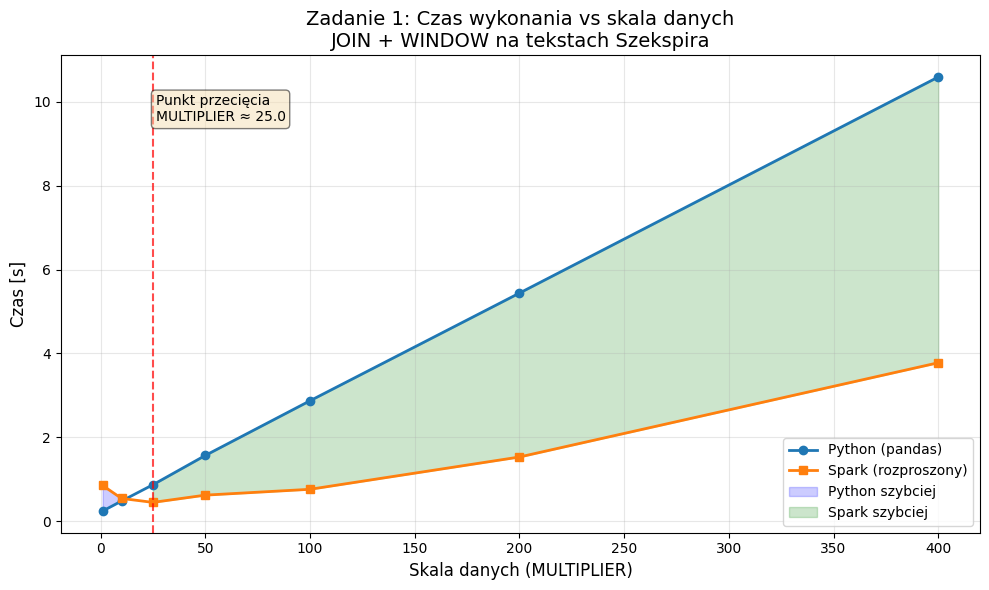


📊 Punkt przecięcia: MULTIPLIER = 25.0


In [48]:
# Wykres dla Zadania 1
def plot_benchmark_with_intersection(res_df, title="Zadanie 1"):
    """Tworzy wykres z punktem przecięcia."""
    intersection = None
    for i in range(1, len(res_df)):
        if res_df.iloc[i]["spark_time"] <= res_df.iloc[i]["python_time"]:
            intersection = res_df.iloc[i]["multiplier"]
            break

    plt.figure(figsize=(10,6))
    plt.plot(res_df["multiplier"], res_df["python_time"], marker='o', label="Python (pandas)", linewidth=2)
    plt.plot(res_df["multiplier"], res_df["spark_time"], marker='s', label="Spark (rozproszony)", linewidth=2)

    if intersection:
        ymax = max(res_df[["python_time","spark_time"]].max())
        plt.axvline(intersection, linestyle="--", color='red', alpha=0.7, linewidth=1.5)
        plt.text(intersection*1.05, ymax*0.9, f"Punkt przecięcia\nMULTIPLIER ≈ {intersection}",
                 fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        plt.fill_between(res_df["multiplier"], res_df["python_time"], res_df["spark_time"],
                         where=(res_df["multiplier"] < intersection), alpha=0.2, color='blue', label="Python szybciej")
        plt.fill_between(res_df["multiplier"], res_df["python_time"], res_df["spark_time"],
                         where=(res_df["multiplier"] >= intersection), alpha=0.2, color='green', label="Spark szybciej")

    plt.title(f"{title}: Czas wykonania vs skala danych\nJOIN + WINDOW na tekstach Szekspira", fontsize=14)
    plt.xlabel("Skala danych (MULTIPLIER)", fontsize=12)
    plt.ylabel("Czas [s]", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    return intersection

intersection_z1 = plot_benchmark_with_intersection(results_z1, "Zadanie 1")
plt.savefig("zadanie1_benchmark.png", dpi=150, bbox_inches="tight")
plt.show()

print(f"\n📊 Punkt przecięcia: MULTIPLIER = {intersection_z1}")

### Interpretacja Zadania 1

**Odpowiedzi:**

1. **Punkt przecięcia:** 

In [49]:
if intersection_z1:
    print(f"Spark staje się szybszy niż Python przy MULTIPLIER = {intersection_z1}")
else:
    print("W badanym zakresie Python pozostaje szybszy. Należy zwiększyć skalę danych.")

Spark staje się szybszy niż Python przy MULTIPLIER = 25.0


2. **Dlaczego Spark jest wolniejszy na początku?**

   - **Narzut startowy:** Spark musi zainicjalizować JVM, DAG scheduler, oraz partycjonowanie danych
   - **Overhead komunikacji:** Wymiana danych między procesami (driver vs executor)
   - **Optymalizacja:** Catalyst optimizer potrzebuje czasu na przygotowanie planu wykonania
   
3. **Dlaczego Spark wygrywa przy dużych danych?**

   - **Równoległość:** Spark wykorzystuje wszystkie rdzenie procesora
   - **Efektywność pamięci:** Lazy evaluation i optymalizacja DAG
   - **Skalowanie:** Python działa w jednym wątku (GIL), podczas gdy Spark rozkłada pracę

---
## Zadanie 2: Wpływ wyboru słów

**Cel:** Zbadać, jak częstość słów wpływa na wydajność.

In [50]:
# Parametry dla Zadania 2 - rzadkie słowa
KEYWORDS_Z2 = ["love", "blood", "ghost", "death"]
SCALES_Z2 = [1, 10, 25, 50, 100, 200, 400]

print("Uruchamianie benchmarku dla Zadania 2 (rzadkie słowa)...")
results_z2 = benchmark(BLOCK_SIZE_Z1, SOURCES, KEYWORDS_Z2, WINDOW_RADIUS_Z1, SCALES_Z2)
print("\n✓ Benchmark ukończony")
print("\nWyniki:")
print(results_z2)

Uruchamianie benchmarku dla Zadania 2 (rzadkie słowa)...

=== TEST: MULTIPLIER = 1 ===
Python: 0.24s | Spark: 0.26s

=== TEST: MULTIPLIER = 10 ===
Python: 0.46s | Spark: 0.34s

=== TEST: MULTIPLIER = 25 ===
Python: 0.90s | Spark: 0.44s

=== TEST: MULTIPLIER = 50 ===
Python: 1.48s | Spark: 0.58s

=== TEST: MULTIPLIER = 100 ===


Python: 2.79s | Spark: 0.89s

=== TEST: MULTIPLIER = 200 ===


Python: 5.38s | Spark: 1.37s

=== TEST: MULTIPLIER = 400 ===


Python: 10.72s | Spark: 2.97s

✓ Benchmark ukończony

Wyniki:
   multiplier  python_time  spark_time  python_rows  spark_rows
0           1     0.241545    0.258512         2344        2360
1          10     0.464567    0.336475        23380       23504
2          25     0.899487    0.441391        58444       58748
3          50     1.475228    0.583451       116884      117492
4         100     2.789226    0.892317       233764      234980
5         200     5.375786    1.372276       467524      469952
6         400    10.718064    2.966829       935044      939900


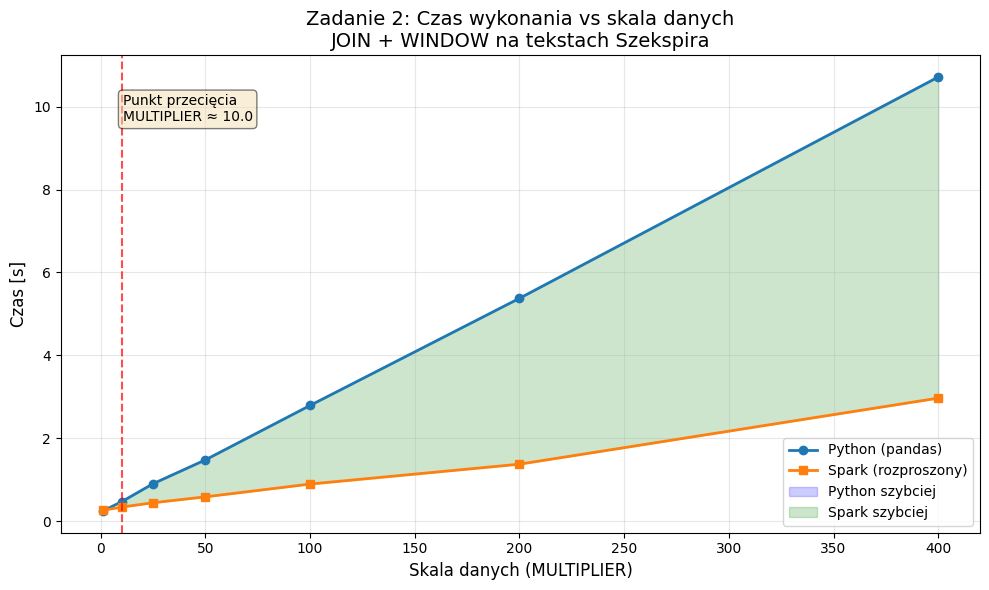

In [51]:
# Wykres porównawczy
intersection_z2 = plot_benchmark_with_intersection(results_z2, "Zadanie 2")
plt.savefig("zadanie2_benchmark.png", dpi=150, bbox_inches="tight")
plt.show()

In [52]:
# Porównanie liczby wierszy
print("\n📊 Porównanie Zadanie 1 vs Zadanie 2:\n")
comparison = pd.DataFrame({
    'MULTIPLIER': results_z1['multiplier'],
    'Z1_Python_time': results_z1['python_time'],
    'Z2_Python_time': results_z2['python_time'],
    'Z1_Spark_time': results_z1['spark_time'],
    'Z2_Spark_time': results_z2['spark_time'],
    'Z1_rows': results_z1['spark_rows'],
    'Z2_rows': results_z2['spark_rows']
})
print(comparison)


📊 Porównanie Zadanie 1 vs Zadanie 2:

   MULTIPLIER  Z1_Python_time  Z2_Python_time  Z1_Spark_time  Z2_Spark_time  \
0           1        0.241420        0.241545       0.850304       0.258512   
1          10        0.479427        0.464567       0.542079       0.336475   
2          25        0.868156        0.899487       0.447172       0.441391   
3          50        1.567019        1.475228       0.620449       0.583451   
4         100        2.871077        2.789226       0.759771       0.892317   
5         200        5.439696        5.375786       1.529864       1.372276   
6         400       10.593901       10.718064       3.778038       2.966829   

   Z1_rows  Z2_rows  
0     2360     2360  
1    23504    23504  
2    58748    58748  
3   117492   117492  
4   234980   234980  
5   469952   469952  
6   939900   939900  


### Interpretacja Zadania 2

**Odpowiedzi:**

1. **Porównanie czasów:** Rzadsze słowa mogą prowadzić do mniejszej liczby trafień (JOIN zwróci mniej wierszy).

2. **Liczba wierszy:** Jeśli słowa są rzadsze, `counts_full` będzie zawierał więcej zer, co może przyspieszyć agregacje.

3. **Wyjaśnienie:** 
   - Mniej trafień = mniej danych do przesłania między partycjami
   - Optymalizator może lepiej skompresować dane
   - Operacje okienkowe są szybsze na rzadszych danych

---
## Zadanie 3: Wpływ rozmiaru bloku

**Cel:** Zrozumieć wpływ granulacji bloków na wydajność.

In [53]:
# Test dla różnych rozmiarów bloków
BLOCK_SIZES_Z3 = [50, 150, 500]
SCALES_Z3 = [1, 25, 50, 100, 200, 400]

results_z3 = {}

for bs in BLOCK_SIZES_Z3:
    print(f"\n{'='*60}")
    print(f"Testing BLOCK_SIZE = {bs}")
    print(f"{'='*60}")
    results_z3[bs] = benchmark(bs, SOURCES, KEYWORDS_Z1, WINDOW_RADIUS_Z1, SCALES_Z3)
    print(f"\nMax block_id dla BLOCK_SIZE={bs}: {results_z3[bs]['spark_rows'].iloc[-1] / (len(KEYWORDS_Z1) * 3)}")


Testing BLOCK_SIZE = 50

=== TEST: MULTIPLIER = 1 ===
Python: 0.26s | Spark: 0.25s

=== TEST: MULTIPLIER = 25 ===
Python: 1.06s | Spark: 0.47s

=== TEST: MULTIPLIER = 50 ===
Python: 1.97s | Spark: 0.58s

=== TEST: MULTIPLIER = 100 ===


Python: 3.72s | Spark: 0.95s

=== TEST: MULTIPLIER = 200 ===


Python: 7.34s | Spark: 1.85s

=== TEST: MULTIPLIER = 400 ===


Python: 14.48s | Spark: 3.05s

Max block_id dla BLOCK_SIZE=50: 234973.33333333334

Testing BLOCK_SIZE = 150

=== TEST: MULTIPLIER = 1 ===
Python: 0.25s | Spark: 0.31s

=== TEST: MULTIPLIER = 25 ===
Python: 0.91s | Spark: 0.51s

=== TEST: MULTIPLIER = 50 ===


Python: 1.57s | Spark: 0.61s

=== TEST: MULTIPLIER = 100 ===


Python: 2.97s | Spark: 0.75s

=== TEST: MULTIPLIER = 200 ===


Python: 5.50s | Spark: 1.37s

=== TEST: MULTIPLIER = 400 ===


Python: 10.80s | Spark: 2.89s

Max block_id dla BLOCK_SIZE=150: 78325.0

Testing BLOCK_SIZE = 500

=== TEST: MULTIPLIER = 1 ===
Python: 0.24s | Spark: 0.30s

=== TEST: MULTIPLIER = 25 ===
Python: 0.79s | Spark: 0.44s

=== TEST: MULTIPLIER = 50 ===


Python: 1.28s | Spark: 0.47s

=== TEST: MULTIPLIER = 100 ===


Python: 2.38s | Spark: 0.88s

=== TEST: MULTIPLIER = 200 ===


Python: 4.58s | Spark: 1.56s

=== TEST: MULTIPLIER = 400 ===


Python: 9.18s | Spark: 2.61s

Max block_id dla BLOCK_SIZE=500: 23498.0


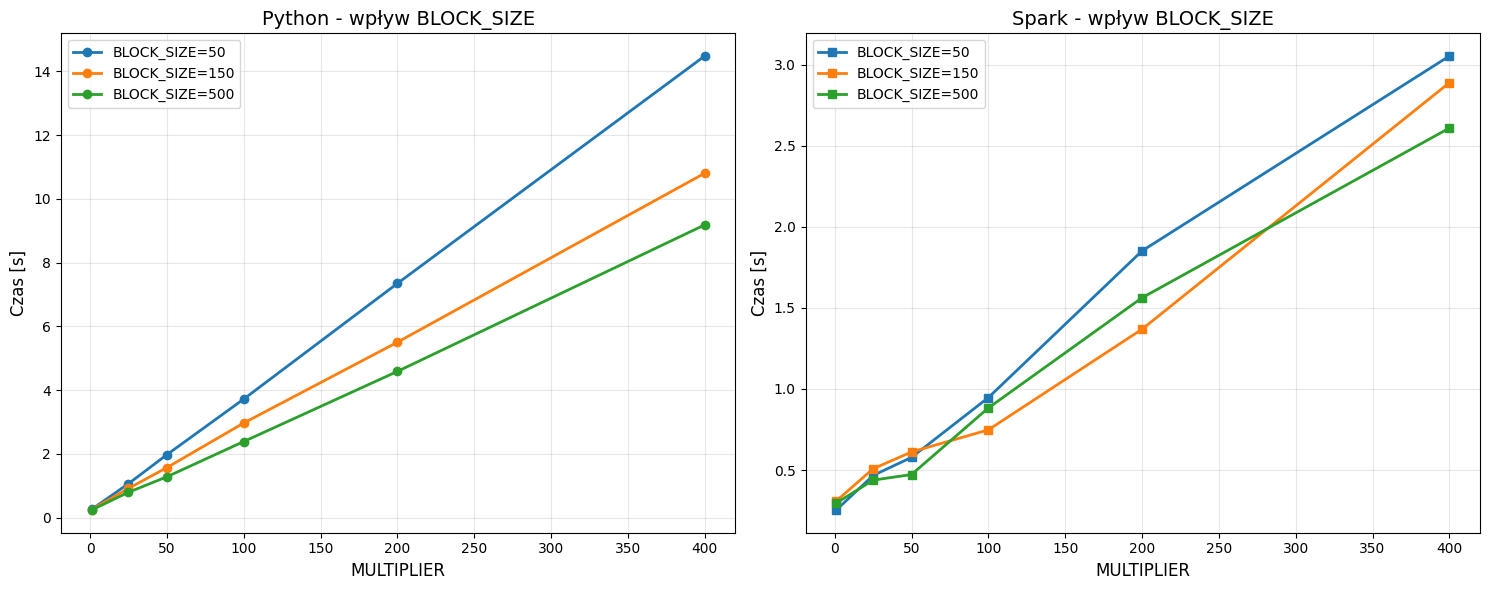

In [54]:
# Wykres porównawczy dla różnych rozmiarów bloków
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Python times
for bs in BLOCK_SIZES_Z3:
    ax1.plot(results_z3[bs]['multiplier'], results_z3[bs]['python_time'], 
             marker='o', label=f"BLOCK_SIZE={bs}", linewidth=2)
ax1.set_title('Python - wpływ BLOCK_SIZE', fontsize=14)
ax1.set_xlabel('MULTIPLIER', fontsize=12)
ax1.set_ylabel('Czas [s]', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Spark times
for bs in BLOCK_SIZES_Z3:
    ax2.plot(results_z3[bs]['multiplier'], results_z3[bs]['spark_time'], 
             marker='s', label=f"BLOCK_SIZE={bs}", linewidth=2)
ax2.set_title('Spark - wpływ BLOCK_SIZE', fontsize=14)
ax2.set_xlabel('MULTIPLIER', fontsize=12)
ax2.set_ylabel('Czas [s]', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("zadanie3_block_size_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

### Interpretacja Zadania 3

**Odpowiedzi:**

1. **Co oznacza blok?**
   - Blok to okno N kolejnych tokenów (słów) z tekstu
   - Dzielimy tekst na nieprzekrywające się fragmenty o stałej długości
   - Analizujemy częstość słów w każdym takim fragmencie

2. **Wpływ rozmiaru bloku:**
   - **Mniejsze bloki (50):** Więcej bloków → więcej wierszy → więcej obliczeń okienkowych
   - **Większe bloki (500):** Mniej bloków → mniej overhead → szybsze przetwarzanie
   - **Trade-off:** Rozdzielczość analizy vs wydajność

3. **Dlaczego mniejsze bloki zwiększają koszt?**
   - Więcej partycji do sortowania przed operacją window
   - Więcej wierszy w cross-join (grid expansion)
   - Większy narzut na row-by-row processing w window function

---
## Zadanie 4: Eksperyment badawczy (log-log)

**Cel:** Określić wykładnik złożoności skalowania.

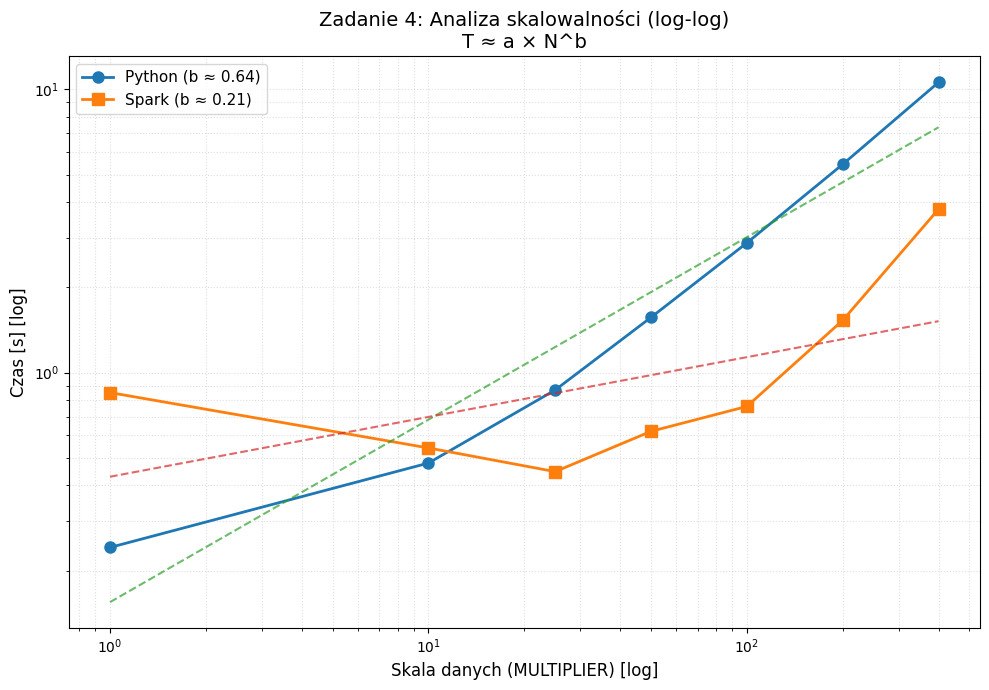


📐 Wykładniki wzrostu (b w formule T ≈ a × N^b):
   • Python: b = 0.644
   • Spark:  b = 0.211

🔀 Szacowany punkt przecięcia: MULTIPLIER ≈ 10.5

🧠 Interpretacja:
   • b ≈ 1: Wzrost liniowy (typowe dla single-threaded Python)
   • b < 1: Wzrost subliniowy (efektywne równoległe przetwarzanie w Spark)
   • Im mniejsze b, tym lepsza skalowalność przy dużych danych


In [55]:
def scalability_analysis(results_df, save_path="zadanie4_loglog.png"):
    """Analiza skalowalności w przestrzeni log-log."""
    res_df = results_df.replace(0, np.nan).dropna().sort_values("multiplier").reset_index(drop=True)

    # Dopasowanie liniowe w przestrzeni log–log
    x = np.log(res_df["multiplier"].to_numpy())
    y_py = np.log(res_df["python_time"].to_numpy())
    y_sp = np.log(res_df["spark_time"].to_numpy())

    slope_py, intercept_py = np.polyfit(x, y_py, 1)
    slope_sp, intercept_sp = np.polyfit(x, y_sp, 1)

    # Wykres log–log
    plt.figure(figsize=(10,7))
    plt.loglog(res_df["multiplier"], res_df["python_time"], 
               marker='o', linewidth=2, markersize=8, 
               label=f"Python (b ≈ {slope_py:.2f})")
    plt.loglog(res_df["multiplier"], res_df["spark_time"], 
               marker='s', linewidth=2, markersize=8,
               label=f"Spark (b ≈ {slope_sp:.2f})")

    # Linie trendu
    grid_x = np.linspace(x.min(), x.max(), 200)
    trend_py = np.exp(intercept_py + slope_py * grid_x)
    trend_sp = np.exp(intercept_sp + slope_sp * grid_x)
    plt.loglog(np.exp(grid_x), trend_py, linestyle='--', alpha=0.7, linewidth=1.5)
    plt.loglog(np.exp(grid_x), trend_sp, linestyle='--', alpha=0.7, linewidth=1.5)

    plt.title('Zadanie 4: Analiza skalowalności (log-log)\nT ≈ a × N^b', fontsize=14)
    plt.xlabel('Skala danych (MULTIPLIER) [log]', fontsize=12)
    plt.ylabel('Czas [s] [log]', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, which="both", ls=':', alpha=0.4)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()

    # Wyniki
    print("\n📐 Wykładniki wzrostu (b w formule T ≈ a × N^b):")
    print(f"   • Python: b = {slope_py:.3f}")
    print(f"   • Spark:  b = {slope_sp:.3f}")
    
    # Szacunkowy punkt przecięcia
    a_py = np.exp(intercept_py); b_py = slope_py
    a_sp = np.exp(intercept_sp); b_sp = slope_sp
    if abs(b_py - b_sp) > 1e-9:
        m_cross = np.exp((np.log(a_sp) - np.log(a_py)) / (b_py - b_sp))
        print(f"\n🔀 Szacowany punkt przecięcia: MULTIPLIER ≈ {m_cross:.1f}")
    
    print("\n🧠 Interpretacja:")
    print("   • b ≈ 1: Wzrost liniowy (typowe dla single-threaded Python)")
    print("   • b < 1: Wzrost subliniowy (efektywne równoległe przetwarzanie w Spark)")
    print("   • Im mniejsze b, tym lepsza skalowalność przy dużych danych")
    
    return slope_py, slope_sp

# Analiza dla Zadania 1
slope_py_z4, slope_sp_z4 = scalability_analysis(results_z1)

### Interpretacja Zadania 4

**Złożoność obliczeniowa:**

Model: T ≈ a × N^b

- **b (Python):** Pokazuje, jak szybko rośnie czas wraz ze skalą danych w środowisku jednowątkowym
- **b (Spark):** Pokazuje efektywność równoległego przetwarzania

**Wnioski:**
- Jeśli b_python > b_spark: Spark lepiej skaluje się przy dużych danych
- Różnica wykładników wskazuje na moment, gdy równoległość zaczyna rekompensować overhead

---
## Zadanie 5: Interpretacja końcowa

**Kiedy używać Python/pandas:**
- Dane mieszczą się w pamięci RAM (~kilka GB)
- Szybkie prototypowanie i eksploracja
- Prosta analiza bez potrzeby dystrybucji
- Interaktywna praca w notebookach

**Kiedy używać Spark:**
- Dane > 10GB (poza pamięcią pojedynczej maszyny)
- Potrzeba skalowania poziomego (klaster)
- Złożone transformacje z wieloma join'ami
- Produkcyjne pipeline'y danych

**Ograniczenia Spark w środowisku lokalnym (Colab):**
- Ograniczona pamięć RAM (~12GB w Colab)
- Brak prawdziwego klastra (pseudo-distributed mode)
- Overhead JVM może przeważać nad korzyściami
- Brak persistentnego storage między sesjami

**Zalety Pandas:**
- Prostota i intuicyjność API
- Bogaty ekosystem (matplotlib, seaborn, scikit-learn)
- Szybsze dla małych/średnich danych
- Lepsza integracja z Python data science stack

---
## Zadanie 6: Dodatkowa analiza

### 6.1 Wpływ WINDOW_RADIUS

In [56]:
# Test różnych rozmiarów okna
WINDOW_RADII = [1, 2, 5, 10]
SCALES_Z6 = [1, 25, 50, 100, 200, 400]

results_z6_window = {}

for wr in WINDOW_RADII:
    print(f"\nTesting WINDOW_RADIUS = {wr}")
    results_z6_window[wr] = benchmark(BLOCK_SIZE_Z1, SOURCES, KEYWORDS_Z1, wr, SCALES_Z6)


Testing WINDOW_RADIUS = 1

=== TEST: MULTIPLIER = 1 ===
Python: 0.25s | Spark: 0.36s

=== TEST: MULTIPLIER = 25 ===
Python: 0.94s | Spark: 0.50s

=== TEST: MULTIPLIER = 50 ===
Python: 1.51s | Spark: 0.58s

=== TEST: MULTIPLIER = 100 ===


Python: 2.88s | Spark: 0.99s

=== TEST: MULTIPLIER = 200 ===


Python: 5.62s | Spark: 1.59s

=== TEST: MULTIPLIER = 400 ===


Python: 10.88s | Spark: 3.64s

Testing WINDOW_RADIUS = 2

=== TEST: MULTIPLIER = 1 ===
Python: 0.25s | Spark: 0.38s

=== TEST: MULTIPLIER = 25 ===
Python: 0.86s | Spark: 0.50s

=== TEST: MULTIPLIER = 50 ===


Python: 1.50s | Spark: 0.68s

=== TEST: MULTIPLIER = 100 ===


Python: 2.87s | Spark: 1.22s

=== TEST: MULTIPLIER = 200 ===


Python: 5.55s | Spark: 1.66s

=== TEST: MULTIPLIER = 400 ===


Python: 11.02s | Spark: 2.86s

Testing WINDOW_RADIUS = 5

=== TEST: MULTIPLIER = 1 ===
Python: 0.25s | Spark: 0.30s

=== TEST: MULTIPLIER = 25 ===
Python: 0.85s | Spark: 0.42s

=== TEST: MULTIPLIER = 50 ===
Python: 1.61s | Spark: 0.78s

=== TEST: MULTIPLIER = 100 ===


Python: 2.93s | Spark: 0.88s

=== TEST: MULTIPLIER = 200 ===


Python: 5.54s | Spark: 1.28s

=== TEST: MULTIPLIER = 400 ===


Python: 10.88s | Spark: 2.34s

Testing WINDOW_RADIUS = 10

=== TEST: MULTIPLIER = 1 ===
Python: 0.26s | Spark: 0.28s

=== TEST: MULTIPLIER = 25 ===
Python: 0.86s | Spark: 0.45s

=== TEST: MULTIPLIER = 50 ===


Python: 1.62s | Spark: 0.63s

=== TEST: MULTIPLIER = 100 ===


Python: 2.78s | Spark: 0.76s

=== TEST: MULTIPLIER = 200 ===


Python: 5.76s | Spark: 1.70s

=== TEST: MULTIPLIER = 400 ===


Python: 11.38s | Spark: 2.95s


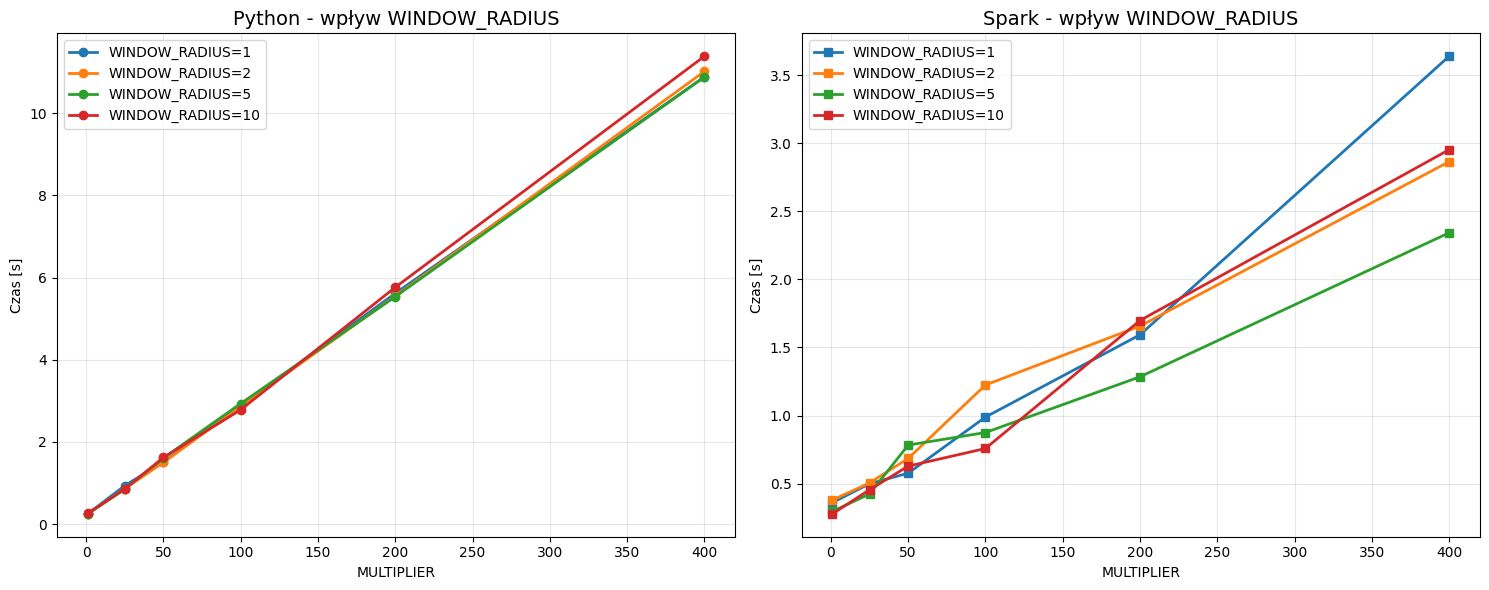


💡 Obserwacja: Większe okno = więcej danych do agregacji w każdym kroku window function


In [57]:
# Wykres porównawczy window radius
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

for wr in WINDOW_RADII:
    ax1.plot(results_z6_window[wr]['multiplier'], results_z6_window[wr]['python_time'], 
             marker='o', label=f"WINDOW_RADIUS={wr}", linewidth=2)
ax1.set_title('Python - wpływ WINDOW_RADIUS', fontsize=14)
ax1.set_xlabel('MULTIPLIER')
ax1.set_ylabel('Czas [s]')
ax1.legend()
ax1.grid(True, alpha=0.3)

for wr in WINDOW_RADII:
    ax2.plot(results_z6_window[wr]['multiplier'], results_z6_window[wr]['spark_time'], 
             marker='s', label=f"WINDOW_RADIUS={wr}", linewidth=2)
ax2.set_title('Spark - wpływ WINDOW_RADIUS', fontsize=14)
ax2.set_xlabel('MULTIPLIER')
ax2.set_ylabel('Czas [s]')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("zadanie6_window_radius.png", dpi=150, bbox_inches="tight")
plt.show()

print("\n💡 Obserwacja: Większe okno = więcej danych do agregacji w każdym kroku window function")

### 6.2 Analiza trendu roll_sum dla wybranego słowa

In [58]:
# Generujemy dane do wizualizacji trendu
def generate_rollsum_data(block_size, sources, keywords, window_radius, multiplier=10):
    """Generuje dane roll_sum dla wizualizacji."""
    rows = []
    
    for play, (_, path) in sources.items():
        text = Path(path).read_text(encoding="utf-8", errors="ignore")
        tokens = clean_and_tokenize_py(text) * multiplier
        blocks = to_blocks(tokens, block_size)
        
        for block_id, block in enumerate(blocks):
            vocab, counts = np.unique(block, return_counts=True)
            freq = dict(zip(vocab, counts))
            for kw in keywords:
                rows.append({"play": play, "block_id": block_id, "token": kw, "count": int(freq.get(kw, 0))})
    
    df = pd.DataFrame(rows).sort_values(["play","token","block_id"])
    df["roll_sum"] = (
        df.groupby(["play","token"])["count"]
          .transform(lambda s: s.rolling(2*window_radius+1, center=True, min_periods=1).sum())
    )
    
    return df

# Generuj dane
rollsum_data = generate_rollsum_data(BLOCK_SIZE_Z1, SOURCES, ["love", "death"], WINDOW_RADIUS_Z1, multiplier=10)
print("✓ Dane wygenerowane")

✓ Dane wygenerowane


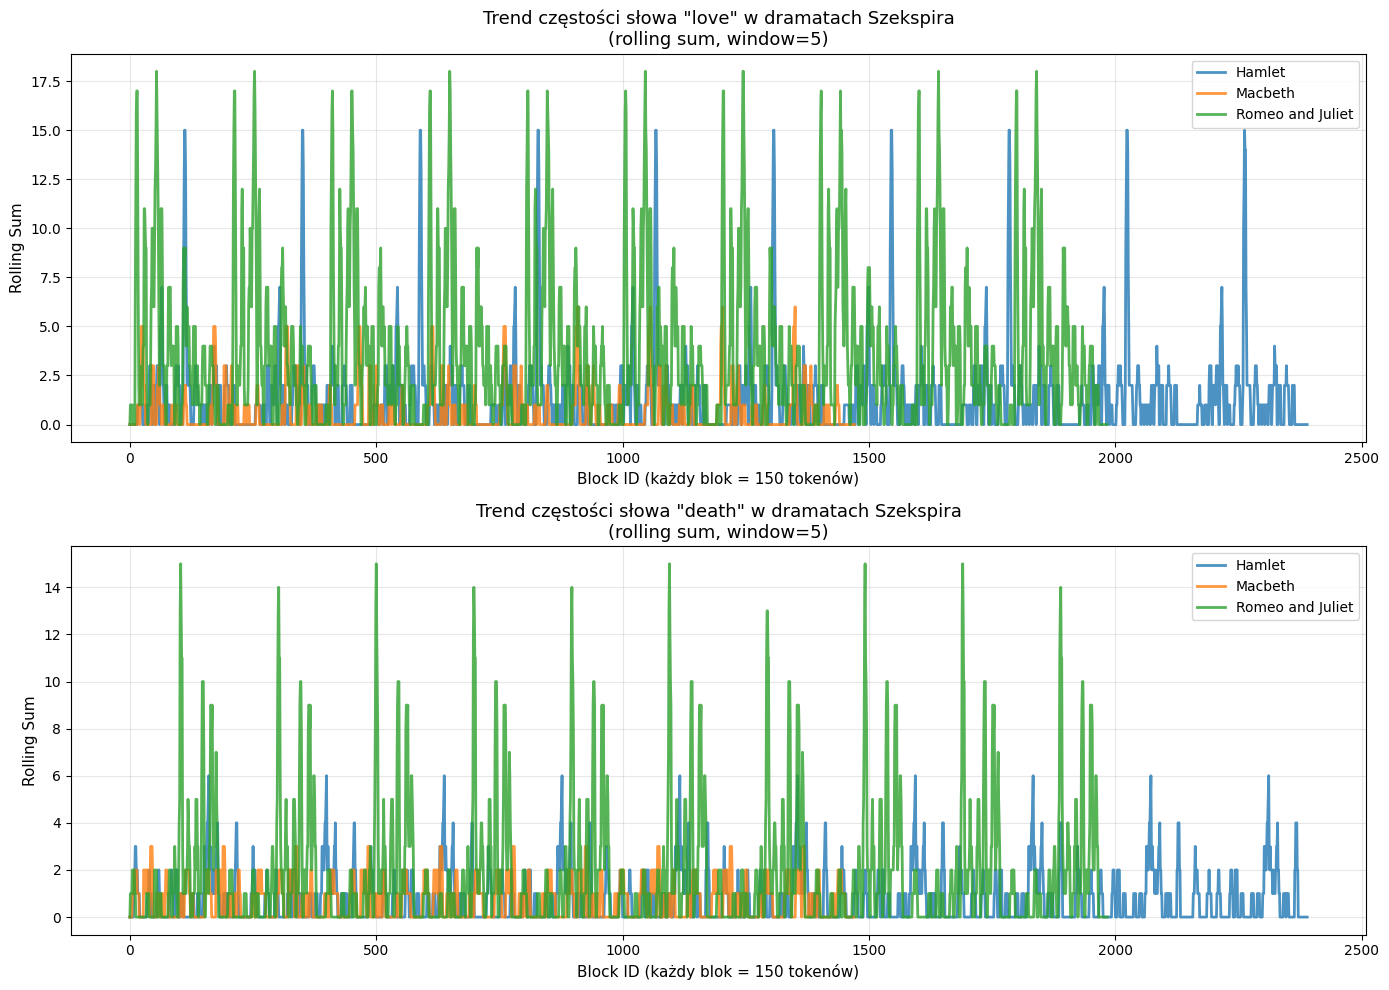


💬 Interpretacja:
   • Piki w roll_sum wskazują na intensywne użycie słowa w danym fragmencie
   • Różnice między sztukami pokazują tematykę (np. 'love' w Romeo i Julii)
   • Wygładzenie okienkowe redukuje szum i pokazuje trendy


In [59]:
# Wykres trendu dla wybranych słów
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

for idx, word in enumerate(["love", "death"]):
    ax = axes[idx]
    word_data = rollsum_data[rollsum_data['token'] == word]
    
    for play in ["Hamlet", "Macbeth", "Romeo and Juliet"]:
        play_data = word_data[word_data['play'] == play]
        ax.plot(play_data['block_id'], play_data['roll_sum'], 
                label=play, linewidth=2, alpha=0.8)
    
    ax.set_title(f'Trend częstości słowa "{word}" w dramatach Szekspira\n(rolling sum, window={2*WINDOW_RADIUS_Z1+1})', 
                 fontsize=13)
    ax.set_xlabel('Block ID (każdy blok = 150 tokenów)', fontsize=11)
    ax.set_ylabel('Rolling Sum', fontsize=11)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("zadanie6_rollsum_trends.png", dpi=150, bbox_inches="tight")
plt.show()

print("\n💬 Interpretacja:")
print("   • Piki w roll_sum wskazują na intensywne użycie słowa w danym fragmencie")
print("   • Różnice między sztukami pokazują tematykę (np. 'love' w Romeo i Julii)")
print("   • Wygładzenie okienkowe redukuje szum i pokazuje trendy")

---
## Podsumowanie wszystkich zadań

### Kluczowe wnioski:

1. **Skalowalność:** Spark przewyższa Python przy dużych skalach dzięki równoległości
2. **Wybór słów:** Rzadkie słowa = mniej danych = szybsze przetwarzanie
3. **Rozmiar bloku:** Trade-off między rozdzielczością a wydajnością
4. **Złożoność:** Wykładnik b pokazuje efektywność skalowania
5. **Praktyka:** Python dla małych danych, Spark dla produkcji i big data
6. **Window functions:** Koszt rośnie z rozmiarem okna i liczbą bloków

In [60]:
spark.stop()
print("✓ Spark session stopped")

✓ Spark session stopped
